In [94]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns

# Loading the data

In [95]:
#IMPORTANT : THIS IS IN EXCEL FORMAT, CHANGE TO CSV IF YOUR FILE IS NOT XLSX
df_q_list = pd.read_excel("C:/Users/tomas/Documents/socialdatascience/question_data.xlsx")

In [96]:
# TAKE A SAMPLE OF DATA
filename = 'C:/Users/tomas/Documents/socialdatascience/user_data_public.csv'
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 2000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df_master = pd.read_csv(filename, 
                        skiprows=skip, 
                        dtype = object)

# Data Structuring and cleaning

In [97]:
# Take only questions with n answers and put the questions in a column
#df_q.N.plot(kind="hist")

n_answers = 20000
df_keep = pd.DataFrame()
df_keep['keep_questions'] = df_q_list[df_q_list["N"]>n_answers].index

In [98]:
#Keep only questions that are also in master dataframe
df_keep = df_keep[df_keep["keep_questions"].isin(list(df_master.columns.values))]

In [99]:
#Count not missing each row i.e: number of answered questions by each preson:
df_master["answered_questions"] = df_master.notnull().sum(axis=1)

In [100]:
#Choose only rows with at least n answered questions
n_questions = 400
df_clean_question = df_master[df_master["answered_questions"]>n_questions]

In [101]:
#Create new dataset with only most answered questions
df_clean_v1 = df_clean_question[list(df_keep["keep_questions"])]

In [102]:
#Create dummy for sexual orientation, where 1 = NOT STRAIGHT
sexual_orientation = []
for x in df_clean_v1['d_orientation']:
    if pd.isnull(x):
        sexual_orientation.append(1) #Since we have persons answered over a 1000 questions, so if they have not answered their sexual orientation we assume they are either uncertain or dont want to disclose because of fear of persecution/judgement from peers
    elif x != "Straight":
        sexual_orientation.append(1)
    else:
        sexual_orientation.append(0)

In [103]:
#Turn it into a dataframe and put labels from dataframe on
y = pd.DataFrame(sexual_orientation, index = df_clean_v1.index)

In [104]:
# Drop sexual orientation from master dataframe
df_clean_v1.drop(columns = ["d_orientation"], inplace = True)
print()

C:\Users\tomas\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [105]:
#UNCOMMENT THIS IF YOU WANT TO SEE HOW MANY ROWS AND QUESTIONS YOU ENDED UP WITH, AND HOW MANY MISSING IN THE ROWS
#df_clean_v1.shape
#df_clean_v1.isnull().sum(axis=1)

In [106]:
#Remove the most problematic questions, and them make all of the categorical variables dummiew
df_prep = df_clean_v1.drop(columns = ["q546", "q1040"])
df_dummy = pd.get_dummies(df_prep, dummy_na = False) #When missing giver 0 to all dummies created for the quesion with the missing value
#df_dummy.fillna(value = -1, inplace = True) #If missing insert -1 # This code does not work
X = df_dummy

In [107]:
#INSERT MISSING VALUES BACK INTO THE DUMMIES FOR LATER IMPUTER
for i in list(df_keep["keep_questions"].head()):
    X.loc[df_prep[i].isnull(), X.columns.str.startswith(i+"_")] = np.nan

# Unsupervised Learning

## Using K-Means to split data into two clusters

In [108]:
# UNSUPERVISED LEARNING CLUSTERS:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score, mean_squared_error as mse

im = Imputer()
X = pd.DataFrame(im.fit_transform(X), index = X.index)

In [109]:
# create kmeans object
kmeans = KMeans(n_clusters=2, random_state=1)

# print location of clusters learned by kmeans object
#print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = pd.DataFrame(kmeans.fit_predict(X), index = y.index) 
accuracy_score(y,y_km)

0.6209503239740821

In [110]:
#Make into DF for add column
df_X = pd.DataFrame(X, index = df_clean_v1.index).copy()
df_X["unsupervised"] = y_km

## Visualisation of unsupervised learning

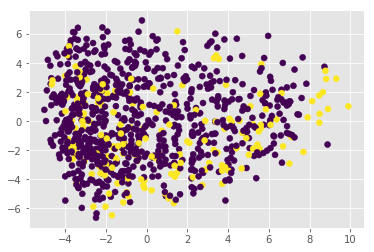

<Figure size 432x288 with 0 Axes>

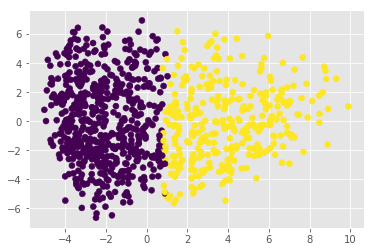

<Figure size 432x288 with 0 Axes>

In [112]:
# We use the PCA to create the first scatterplot, which shows the distribution of "not straight" in the actual data

plt.style.use('ggplot')

pca_2d = PCA(n_components=2).fit_transform(X)

fig1, ax = plt.subplots(1,1)

#Here we make a reference plot to see whether there is a big difference between the actual classes and the predicted
plt.figure('Reference Plot')
ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c = y.values.ravel())

fig1.savefig('C:/Users/tomas/Documents/socialdatascience/sample_cluster1.png', bbox_inches='tight')

fig2, ax = plt.subplots(1,1)

#Then, we plot the K-Mean clusters that are trying to predict the categories.
plt.figure('K-means with 2 clusters')
ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c = kmeans.labels_)

fig2.savefig('C:/Users/tomas/Documents/socialdatascience/sample_cluster2.png', bbox_inches='tight')

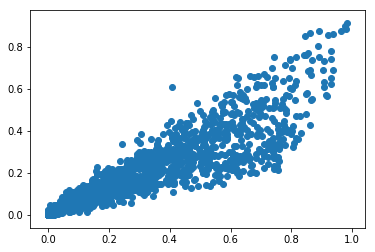

In [88]:
plt.scatter(kmeans.cluster_centers_[0,:], kmeans.cluster_centers_[1,:])

In [89]:
print(kmeans.cluster_centers_)

[[0.258693   0.741307   0.16054022 ... 0.00157729 0.00157729 0.98264984]
 [0.24948347 0.75051653 0.22848034 ... 0.         0.         0.91233766]]


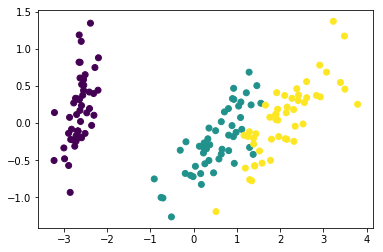

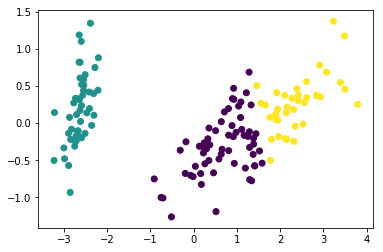

In [90]:
# From https://www.dummies.com/programming/big-data/data-science/how-to-visualize-the-clusters-in-a-k-means-unsupervised-learning-model/
# This is just an example to show how clustering can be visualized in the iris dataset

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
import pylab as pl
iris = load_iris()
pca = PCA(n_components=2).fit(iris.data)
pca_2d = pca.transform(iris.data)
pl.figure('Reference Plot')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=iris.target)
kmeans = KMeans(n_clusters=3, random_state=111)
kmeans.fit(iris.data)
pl.figure('K-means with 3 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
pl.show()

## Set up a logistic regression (LASSO)

In [91]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

In [92]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

im = Imputer()
X_train = im.fit_transform(X_train)
X_dev = im.fit_transform(X_dev)
X_test = im.transform(X_test)
X_val = im.transform(X_val)

# LOGISTIC REGRESSION

pipe_lasso = make_pipeline(LogisticRegression(random_state= 1))
pipe_lasso.fit(X_train,y_train.values.ravel())
y_pred = pipe_lasso.predict(X_val)
y_pred_test = pipe_lasso.predict(X_test)
print(accuracy_score(y_val, y_pred))
print()
print(accuracy_score(y_test, y_pred_test))

0.8757961783439491

0.8630573248407644


# Supervised Learning

In [411]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

In [412]:
# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# splitting development into train (1/2) and validation (1/2)
#X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

# Decision Tree Classifier

In [42]:
#USE FOLDS TO FIND OPTIMAL HYPERPARAMETER
from datetime import datetime as dt
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
kfolds = KFold(n_splits=10)
accuracy = []
im = Imputer()
start = dt.now()
for x in range(1,11):
    tree = DecisionTreeClassifier(criterion="gini", max_depth= x, random_state=1)  
    accuracy_ = []
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):

        X_train, y_train, = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        
        X_train = pd.DataFrame(im.fit_transform(X_train),index = X_train.index)
        X_val = pd.DataFrame(im.transform(X_val), index = X_val.index)

        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_val)
        accuracy_.append(accuracy_score(y_val, y_pred))    
    accuracy.append(accuracy_)
temp = pd.DataFrame(accuracy).mean()
temp.index = range(1,11)
optimal = temp.nlargest(1)
print("Time:", (dt.now() - start).total_seconds())

Time: 2.365915


In [43]:
tree = DecisionTreeClassifier(criterion='gini', max_depth= optimal.index[0], random_state=1)

X_test = pd.DataFrame(im.fit_transform(X_test), index= X_test.index)
X_dev = pd.DataFrame(im.transform(X_dev), index= X_dev.index)

tree.fit(X_dev, y_dev)
predict = pd.DataFrame(tree.predict(X_test),index = y_test.index)
print(accuracy_score(y_test, predict))

0.65


# Random Forest Classifier - With Default Values

In [413]:
#USE FOLDS TO FIND OPTIMAL HYPERPARAMETER FOR RANDOM FOREST
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
kfolds = KFold(n_splits=10)
accuracy = []
im = Imputer()

for x in range(1,11):
    tree = RandomForestClassifier(criterion="gini", max_depth= x, random_state=1, n_estimators= 100)  
    accuracy_ = []
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):

        X_train, y_train, = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx] 
        
        X_train = pd.DataFrame(im.fit_transform(X_train),index = X_train.index)
        X_val = pd.DataFrame(im.transform(X_val), index = X_val.index)

        tree.fit(X_train, y_train.values.ravel())
        y_pred = tree.predict(X_val)
        accuracy_.append(accuracy_score(y_val, y_pred))    
    accuracy.append(accuracy_)
temp = pd.DataFrame(accuracy).mean()
temp.index = range(1,11)
optimal_r = temp.nlargest(1)

In [416]:
tree = RandomForestClassifier(criterion='gini', max_depth= optimal_r.index[0], random_state=1)

X_test = pd.DataFrame(im.fit_transform(X_test), index= X_test.index)
X_dev = pd.DataFrame(im.transform(X_dev), index= X_dev.index)

tree.fit(X_dev, y_dev.values.ravel())
predict = pd.DataFrame(tree.predict(X_test),index = y_test.index)
print(accuracy_score(y_test, predict))

0.826133909287257


# STOP HERE AGAIN

In [ ]:
# THIS IS A TEST USING A DECISION TREE

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error as mse
from sklearn.preprocessing import Imputer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1, stratify=y)
tree = DecisionTreeClassifier(criterion='gini', max_depth= optimal, random_state=1)

#IMPUTER REPLACE MISSINGS WITH THE MEAN OF THE COLUMN
im = Imputer()
X_train = pd.DataFrame(im.fit_transform(X_train), index = X_train)
X_test = pd.DataFrame(im.transform(X_test), index= X_test)

# FIT AND PREDICT THE TREE
tree.fit(X_train, y_train)
predict = pd.DataFrame(tree.predict(X_test),index = y_test.index)
print(accuracy_score(y_test, predict)) #This shows the accuracy of our decision tree
print(y_test.mean()) #This shows how many not straight rows in the dataset
print(mse(predict, y_test))

In [ ]:
# THIS IS A TEST USING A DECISION TREE

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error as mse
from sklearn.preprocessing import Imputer


X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.3, random_state=1, stratify=y)

errors = []
accuracy = []

for i in ["entropy", "gini"]:
    errors_ = []
    accuracy_ = []
    for x in range(1,10):

        tree = DecisionTreeClassifier(criterion=i, max_depth= x, random_state=1)

        #IMPUTER REPLACE MISSINGS WITH THE MEAN OF THE COLUMN
        im = Imputer()
        X_train = im.fit_transform(X_train)
        X_test = im.transform(X_test)

        # FIT AND PREDICT THE TREE
        tree.fit(X_train, y_train)
        predict = pd.DataFrame(tree.predict(X_test),index = y_test.index)
        accuracy_.append(accuracy_score(y_test, predict)) #This shows the accuracy of our decision tree #This shows how many not straight rows in the dataset
        errors_.append(mse(predict, y_test)**(1/2))
    errors.append(errors_)
    accuracy.append(accuracy_)

In [417]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error as mse
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.3, random_state=1, stratify=y)

errors = []
accuracy = []

for i in ["entropy", "gini"]:
    errors_ = []
    accuracy_ = []
    for x in range(1,11):

        tree = RandomForestClassifier(criterion=i, max_depth= x, random_state=1, n_estimators = 100)

        #IMPUTER REPLACE MISSINGS WITH THE MEAN OF THE COLUMN
        im = Imputer()
        X_train = im.fit_transform(X_train)
        X_test = im.transform(X_test)

        # FIT AND PREDICT THE TREE
        tree.fit(X_train, y_train.values.ravel())
        predict = pd.DataFrame(tree.predict(X_test),index = y_test.index)
        accuracy_.append(accuracy_score(y_test, predict)) #This shows the accuracy of our decision tree #This shows how many not straight rows in the dataset
        errors_.append(mse(predict, y_test)**(1/2))
    errors.append(errors_)
    accuracy.append(accuracy_)

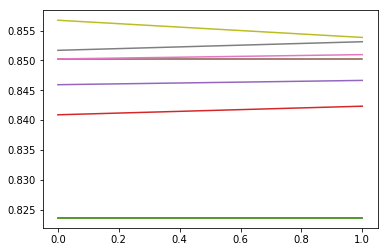

In [420]:
plt.plot(accuracy)

In [ ]:
#pd.DataFrame(errors[0]).plot()

In [421]:
accuracy[0]

[0.8236141108711303,
 0.8236141108711303,
 0.8236141108711303,
 0.8408927285817135,
 0.8459323254139669,
 0.8502519798416127,
 0.8502519798416127,
 0.8516918646508279,
 0.8567314614830813]

In [ ]:
pd.DataFrame(accuracy[0]).plot()

In [ ]:
pd.DataFrame(accuracy[1]).plot()